# I. Imports and Data Loading

In [2]:
%pip install kagglehub

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

## Load the dataset

In [4]:
path = kagglehub.dataset_download("nalisha/e-commerce-sales-and-profit-analysis-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\ayazb\.cache\kagglehub\datasets\nalisha\e-commerce-sales-and-profit-analysis-dataset\versions\1


In [5]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

df = pd.read_csv(full_path)

In [6]:
full_path

'C:\\Users\\ayazb\\.cache\\kagglehub\\datasets\\nalisha\\e-commerce-sales-and-profit-analysis-dataset\\versions\\1\\ecommerce_sales_data (2).csv'

## Data Cleaning

In [7]:
df.columns = [c.replace(' ', '_') for c in df.columns]
print(df.head())
print(df.info())

   Order_Date Product_Name     Category Region  Quantity  Sales  Profit
0  2024-12-31      Printer       Office  North         4   3640  348.93
1  2022-11-27        Mouse  Accessories   East         7   1197  106.53
2  2022-05-11       Tablet  Electronics  South         5   5865  502.73
3  2024-03-16        Mouse  Accessories  South         2    786  202.87
4  2022-09-10        Mouse  Accessories   West         1    509  103.28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Date    3500 non-null   object 
 1   Product_Name  3500 non-null   object 
 2   Category      3500 non-null   object 
 3   Region        3500 non-null   object 
 4   Quantity      3500 non-null   int64  
 5   Sales         3500 non-null   int64  
 6   Profit        3500 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 191.5+ KB
None


# II. Descriptive Statistics

In [8]:
# We will compare Profit across different Categories
summary = df.groupby('Category')['Profit'].agg(['mean', 'std', 'count'])
print("Summary Statistics by Category:")
print(summary)

Summary Statistics by Category:
                   mean         std  count
Category                                  
Accessories  525.399529  500.810931   1401
Electronics  529.957285  511.215915   1742
Office       519.313389  483.209170    357


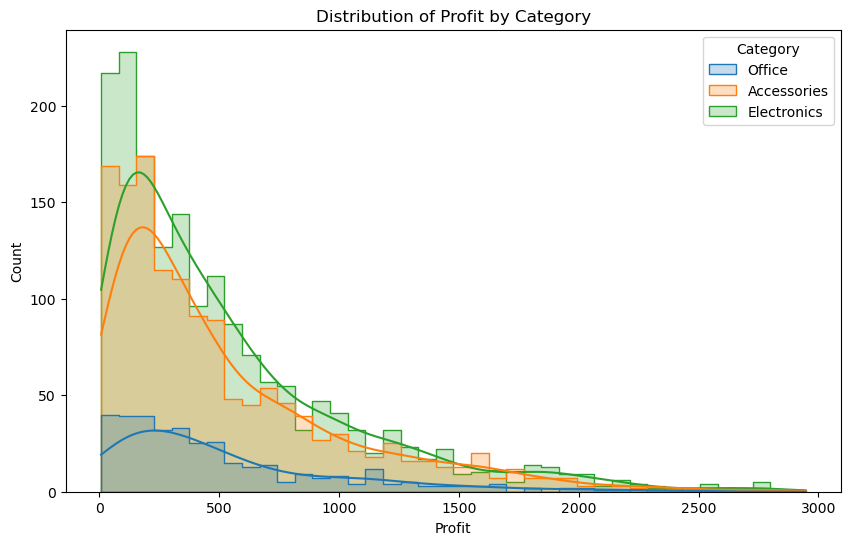

In [9]:
# Visualizing the distribtuion
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Profit', hue='Category', kde=True, element="step")
plt.title('Distribution of Profit by Category')
plt.show()

# III. Hypothesis Test 1 - Two-Sample T-Test

## Question: Is there a significant difference in Profit between 'Office Supplies' and 'Technology'?

In [10]:
df

,Order_Date,Product_Name,Category,Region,Quantity,Sales,Profit
0,2024-12-31,Printer,Office,North,4,3640,348.93
1,2022-11-27,Mouse,Accessories,East,7,1197,106.53
2,2022-05-11,Tablet,Electronics,South,5,5865,502.73
3,2024-03-16,Mouse,Accessories,South,2,786,202.87
4,2022-09-10,Mouse,Accessories,West,1,509,103.28
...,...,...,...,...,...,...,...
3495,2023-02-15,Monitor,Accessories,North,4,4064,771.16
3496,2022-09-18,Monitor,Accessories,East,1,1117,119.89
3497,2022-04-12,Laptop,Electronics,South,4,260,66.02
3498,2022-01-18,Printer,Office,South,3,222,50.28


In [90]:
# Filter groups:
office = df[df['Category'] == 'Office Supplies']['Profit']
tech = df[df['Category'] == 'Technology']['Profit']

In [11]:
from scipy import stats

# Filter groups (ВАЖНО: реальные названия категорий)
office = df[df['Category'] == 'Office']['Profit']
tech = df[df['Category'] == 'Electronics']['Profit']

# На всякий случай убираем NaN
office = office.dropna()
tech = tech.dropna()

print("Office sample size:", len(office))
print("Tech sample size:", len(tech))

# T-test (Welch)
t_stat, p_val = stats.ttest_ind(office, tech, equal_var=False)

print("--- T-Test Results ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

alpha = 0.05
if p_val < alpha:
    print("Result: Reject the Null Hypothesis (Significant difference found)")
else:
    print("Result: Fail to reject the Null Hypothesis")


Office sample size: 357
Tech sample size: 1742
--- T-Test Results ---
T-statistic: -0.3754
P-value: 7.0754e-01
Result: Fail to reject the Null Hypothesis


# IV. Hypothesis Test 2 - ANOVA

## Question: Does Profit vary significantly across different Regions?

In [112]:
# H0: All region means are equal
# H1: At least one region mean is different

model = ols('Profit ~ C(Region)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\n--- ANOVA Results ---")
print(anova_table)


--- ANOVA Results ---
                 sum_sq      df         F    PR(>F)
C(Region)  1.526893e+06     3.0  2.004284  0.111195
Residual   8.877680e+08  3496.0       NaN       NaN


## Visualizing for the report

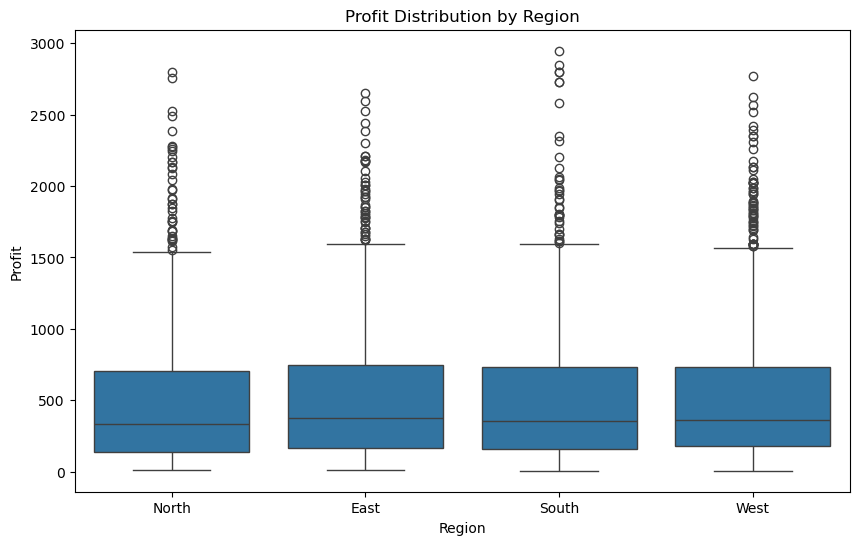

In [128]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Profit', data=df)
plt.title('Profit Distribution by Region')
plt.show()

# V. Confidence Intervals

In [142]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean, lower, upper = confidence_interval(df['Profit'])
print(f"\n95% Confidence Interval for overall Mean Profit: ({lower:.2f}, {upper:.2f})")


95% Confidence Interval for overall Mean Profit: (510.34, 543.75)
